
# DP‑MLM Project 

**What this notebook gives you**
- Clean, reproducible structure to run your **replication + new‑data** demo.
- Minimal **patched DP‑MLM** class with the stability fixes we discussed.
- Tiny **sanity run** cells (ε = 16/8/4) and a **batch demo** cell scaffold.
- It won’t run here because model downloads need internet/GPU, but it will run **on your machine**.

**How to use**
1. Open this notebook in your local Jupyter.
2. Run cells top‑to‑bottom. If a cell fails, read the inline comments — quick fixes are included.
3. Record your 60–90s screen capture from the **Sanity Run** and **Batch Demo** sections.


## 0. Environment & installs

In [3]:

# If you're in a fresh environment, uncomment the following:
# %pip install torch transformers nltk wn importlib_resources scikit-learn evaluate tqdm

import os, sys, json, random, string, numpy as np, torch
import nltk, wn
from collections import Counter
from textwrap import dedent
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, logging as hf_logging
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

hf_logging.set_verbosity_warning()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Create local data folder for vocab/opposites if missing (fallbacks)
os.makedirs("data", exist_ok=True)
if not os.path.exists("data/opposites.json"):
    with open("data/opposites.json", "w", encoding="utf-8") as f:
        json.dump({"good": ["bad", "evil"], "increase": ["decrease"]}, f, ensure_ascii=False, indent=2)
if not os.path.exists("data/vocab.txt"):
    with open("data/vocab.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(["the","a","an","company","acquiring","startup","boost","capabilities","market","apple","google","microsoft","news"]))        


## 1. NLTK resources 

In [5]:
# 1) Imports
import nltk, wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import wordnet as nltkwn  # used in fallback

# 2) NLTK resources first
def _safe_nltk_download(key, name=None):
    try:
        nltk.data.find(key)
    except LookupError:
        nltk.download(name or key.split('/')[-1], quiet=True)

for key, name in [
    ('tokenizers/punkt', 'punkt'),
    ('corpora/stopwords', 'stopwords'),
    ('corpora/wordnet', 'wordnet'),
    ('taggers/averaged_perceptron_tagger', 'averaged_perceptron_tagger'),
    ('corpora/words', 'words'),
]:
    _safe_nltk_download(key, name)

stop = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
detokenizer = TreebankWordDetokenizer()

# 3) OEWN if available; otherwise NLTK WordNet (this is the block I gave you)
USE_OEWN = True
try:
    en = wn.Wordnet('oewn:2022')
except Exception:
    try:
        wn.download('oewn:2022')  # will succeed only if you have internet
        en = wn.Wordnet('oewn:2022')
    except Exception:
        en = None
        USE_OEWN = False
        print("OEWN not available; using NLTK's wordnet fallback.")

def _synsets(word): return en.synsets(word) if USE_OEWN else nltkwn.synsets(word)

def _antonyms(word):
    if USE_OEWN:
        ants = []
        for ss in en.synsets(word):
            for sense in ss.senses():
                ants += [x.word().lemma() for x in sense.get_related("antonym")]
        return sorted(set(ants))
    else:
        ants = []
        for ss in nltkwn.synsets(word):
            for l in ss.lemmas():
                ants += [a.name() for a in l.antonyms()]
        return sorted(set(ants))

def _hypernyms(word):
    if USE_OEWN:
        out = []
        for ss in en.synsets(word):
            for h in ss.hypernyms():
                out += [l.lemma() for l in h.words()]
        return sorted(set(out))
    else:
        out = []
        for ss in nltkwn.synsets(word):
            for h in ss.hypernyms():
                out += [l.name() for l in h.lemmas()]
        return sorted(set(out))

def _hyponyms(word):
    if USE_OEWN:
        out = []
        for ss in en.synsets(word):
            for sense in ss.senses():
                out += [x.word().lemma() for x in sense.get_related("hyponyms")]
        return sorted(set(out))
    else:
        out = []
        for ss in nltkwn.synsets(word):
            for h in ss.hyponyms():
                out += [l.name() for l in h.lemmas()]
        return sorted(set(out))

def _derivational(word):
    if USE_OEWN:
        out = []
        for ss in en.synsets(word):
            for sense in ss.senses():
                out += [x.word().lemma() for x in sense.get_related("derivation")]
        return sorted(set(out))
    else:
        out = []
        for ss in nltkwn.synsets(word):
            for l in ss.lemmas():
                out += [x.name() for x in l.derivationally_related_forms()]
        return sorted(set(out))

def _pertainyms(word):
    if USE_OEWN:
        out = []
        for ss in en.synsets(word):
            for sense in ss.senses():
                out += [x.word().lemma() for x in sense.get_related("pertainym")]
        return sorted(set(out))
    else:
        out = []
        for ss in nltkwn.synsets(word):
            for l in ss.lemmas():
                out += [x.name() for x in l.pertainyms()]
        return sorted(set(out))

def get_antonyms(word): return _antonyms(word)
def get_hypernyms(word): return _hypernyms(word)
def get_hyponyms(word): return _hyponyms(word)
def get_related_forms(word): return _derivational(word)
def get_pertainyms(word): return _pertainyms(word)

def get_general_nym(word, nym):
    if USE_OEWN:
        out = []
        for ss in en.synsets(word):
            for sense in ss.senses():
                out += [x.word().lemma() for x in sense.get_related(nym)]
        return sorted(set(out))
    else:
        out = []
        for ss in nltkwn.synsets(word):
            if nym.startswith('mero'):
                groups = (ss.part_meronyms(), ss.member_meronyms(), ss.substance_meronyms())
            elif nym.startswith('holo'):
                groups = (ss.part_holonyms(), ss.member_holonyms(), ss.substance_holonyms())
            else:
                groups = ()
            for g in groups:
                for s in g:
                    out += [l.name() for l in s.lemmas()]
        return sorted(set(out))

def get_nyms(word, depth=-1):
    nym_list = ['antonyms','hypernyms','hyponyms','holonyms','meronyms','pertainyms','derivationally_related_forms']
    results = []
    for nym in nym_list:
        if nym=='antonyms': results.append(set(get_antonyms(word)))
        elif nym=='hypernyms': results.append(set(get_hypernyms(word)))
        elif nym=='hyponyms': results.append(set(get_hyponyms(word)))
        elif nym=='pertainyms': results.append(set(get_pertainyms(word)))
        elif nym=='derivationally_related_forms': results.append(set(get_related_forms(word)))
        elif nym=='holonyms':
            results.append(set(get_general_nym(word, "holo_member")+get_general_nym(word, "holo_part")+get_general_nym(word, "holo_substance")))
        elif nym=='meronyms':
            results.append(set(get_general_nym(word, "mero_member")+get_general_nym(word, "mero_part")+get_general_nym(word, "mero_substance")))
    return dict(zip(nym_list, results))


In [6]:
print("OEWN installed and active")
print("antonyms('increase') →", list(sorted(list(get_antonyms("increase")))[:5]))
print("hypernyms('dog') →", list(sorted(list(get_hypernyms("dog")))[:5]))


OEWN installed and active
antonyms('increase') → ['decrease', 'decrement']
hypernyms('dog') → ['blighter', 'bloke', 'canid', 'canine', 'catch']


## 2. Small helpers

In [8]:

def nth_repl(s, sub, repl, n):
    s_split = s.split()
    i = 0
    try:
        find = s_split.index(sub); i += 1
    except ValueError:
        return s
    while i != n:
        try:
            find = s_split.index(sub, find + 1); i += 1
        except ValueError:
            break
    if i == n:
        return " ".join(s_split[:find] + [repl] + s_split[find+1:])
    return s

def nth_rem(s, sub, n):
    s_split = s.split()
    i = 0
    try:
        find = s_split.index(sub); i += 1
    except ValueError:
        return s
    while i != n:
        try:
            find = s_split.index(sub, find + 1); i += 1
        except ValueError:
            break
    if i == n:
        return " ".join(s_split[:find] + s_split[find+1:])
    return s

def sentence_enum(tokens):
    counts = Counter()
    return [counts.__setitem__(t, counts.get(t,0)+1) or counts[t] for t in tokens]


## 3. WordNet helpers 

In [10]:

def get_antonyms(word):
    ants = []
    for ss in en.synsets(word):
        for sense in ss.senses():
            ants.extend([x.word().lemma() for x in sense.get_related("antonym")])
    syns = []
    for w in set(ants):
        for ss in en.synsets(w):
            syns.extend(ss.lemmas())
    return sorted(set(syns))

def get_pertainyms(word):
    perts = []
    for ss in en.synsets(word):
        for sense in ss.senses():
            perts.extend([x.word().lemma() for x in sense.get_related("pertainym")])
    return sorted(set(perts))

def get_hyponyms(word):
    hypo = []
    for ss in en.synsets(word):
        for sense in ss.senses():
            hypo.extend([x.word().lemma() for x in sense.get_related("hyponyms")])
    return sorted(set(hypo))

def get_hypernyms(word):
    hyper = []
    for ss in en.synsets(word):
        for h in ss.hypernyms():
            hyper.extend([x.lemma() for x in h.words()])
    return sorted(set(hyper))

def get_related_forms(word):
    forms = []
    for ss in en.synsets(word):
        for sense in ss.senses():
            forms.extend([x.word().lemma() for x in sense.get_related("derivation")])
    return sorted(set(forms))

def get_general_nym(word, nym):
    n = []
    for ss in en.synsets(word):
        for sense in ss.senses():
            n.extend([x.word().lemma() for x in sense.get_related(nym)])
    return sorted(set(n))

def get_nyms(word, depth=-1):
    nym_list = ['antonyms','hypernyms','hyponyms','holonyms','meronyms','pertainyms','derivationally_related_forms']
    results = []
    w = lemmatizer.lemmatize(word)
    for nym in nym_list:
        if nym=='antonyms':
            results.append(get_antonyms(w))
        elif nym=='hypernyms':
            results.append(get_hypernyms(w))
        elif nym=='hyponyms':
            results.append(get_hyponyms(w))
        elif nym in ['holonyms','meronyms']:
            res = []
            for postfix in ["_member","_part","_portion","_substance"]:
                res.extend(get_general_nym(w, f"{nym[:4]}{postfix}"))
            results.append(res)
        elif nym=='pertainyms':
            results.append(get_pertainyms(w))
        else:
            results.append(get_related_forms(w))
    return dict(zip(nym_list, map(set, results)))


## 4. Resource loaders (with local fallbacks)

In [12]:

def get_opposites():
    try:
        # Try package resource first
        import importlib_resources as impresources
        with open(impresources.files("DPMLM") / "data" / "opposites.json", "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        with open("data/opposites.json", "r", encoding="utf-8") as f:
            return json.load(f)

def get_vocab():
    try:
        import importlib_resources as impresources
        with open(impresources.files("DPMLM") / "data" / "vocab.txt", "r", encoding="utf-8") as f:
            return set(x.strip() for x in f.readlines())
    except Exception:
        with open("data/vocab.txt", "r", encoding="utf-8") as f:
            return set(x.strip() for x in f.readlines())


## 5. Scoring helpers

In [14]:

def similarity_score(original_output, subst_output, k):
    mask_idx = k
    cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    # average attentions across layers/heads
    weights = torch.div(torch.stack(list(original_output[3])).squeeze().sum(0).sum(0), (12 * 12.0))
    suma = 0.0
    sent_len = original_output[2][2].shape[1]
    for token_idx in range(sent_len):
        original_hidden = original_output[2]
        subst_hidden = subst_output[2]
        context_original = torch.cat(tuple([original_hidden[hs_idx][:, token_idx, :] for hs_idx in [1,2,3,4]]), dim=1)
        context_subst   = torch.cat(tuple([subst_hidden[hs_idx][:, token_idx, :]   for hs_idx in [1,2,3,4]]), dim=1)
        suma += weights[mask_idx][token_idx] * cos_sim(context_original, context_subst)
    return suma

def proposal_score(original_score, subst_scores, device):
    subst_scores = torch.tensor(subst_scores).to(device)
    return np.log(torch.div(subst_scores, (1.0 - original_score)).cpu())


## 6. Safer candidate filtering (no index drift)

In [16]:

def filter_words(target, words, scr, tkn, opp={}):
    toks = tkn.tolist()
    nyms = get_nyms(target)
    lem = WordNetLemmatizer()

    antonyms = set(nyms['antonyms'])
    tl = lem.lemmatize(target.lower())
    if tl in opp:
        antonyms |= set(opp[tl])

    keep_idx = []
    lower_set = set(w.lower() for w in words)
    for i, w in enumerate(words):
        if w.upper() == w and w.lower() in lower_set:
            continue
        if lem.lemmatize(w.lower()) in antonyms:
            continue
        keep_idx.append(i)

    words = [words[i] for i in keep_idx]
    scr   = [scr[i]   for i in keep_idx]
    toks  = [toks[i]  for i in keep_idx]
    return words, scr, torch.tensor(toks)


## 7. DPMLM class (patched for demo safety)

In [18]:

class DPMLM():
    opposites = get_opposites()
    vocab = get_vocab()
    lemmatizer = WordNetLemmatizer()
    detokenizer = TreebankWordDetokenizer()
    tokenizer = None
    lm_model = None
    raw_model = None
    device = None
    alpha = None

    def __init__(self, MODEL="roberta-base", alpha=0.003):
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL)
        self.lm_model = AutoModelForMaskedLM.from_pretrained(MODEL)
        self.raw_model = AutoModel.from_pretrained(MODEL, output_hidden_states=True, output_attentions=True)
        self.alpha = alpha

        # clipping config for TEMP sampling
        self.clip_min = -3.2093127
        self.clip_max = 16.304797887802124
        self.sensitivity = abs(self.clip_max - self.clip_min)

        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.lm_model.to(self.device).eval()
        self.raw_model.to(self.device).eval()

    def load_transformers(self):
        return self.tokenizer, self.lm_model, self.raw_model

    def calc_scores(self, scr, sentences, original_output, original_score, mask_index):
        _, _, raw_model = self.load_transformers()
        with torch.no_grad():
            subst_output = raw_model(sentences)
        prop_score = proposal_score(original_score, scr, self.device)
        substitute_validation = similarity_score(original_output, subst_output, mask_index)
        final_score = substitute_validation.cpu() + self.alpha*prop_score
        return final_score, prop_score, substitute_validation

    def privatize(self, sentence, target, n=1, K=5, CONCAT=True, FILTER=True, ENGLISH=False, epsilon=1, MS=None, TEMP=False, POS=False):
        split_sent = nltk.word_tokenize(sentence)
        original_sent = ' '.join(split_sent)

        if MS is None:
            masked_sent = ' '.join(split_sent)
        else:
            masked_sent = MS

        if isinstance(target, list):
            if n == 1:
                n = [1 for _ in range(len(target))]
            for t, nn in zip(target, n):
                masked_sent = nth_repl(masked_sent, t, self.tokenizer.mask_token, nn)
        else:
            masked_sent = nth_repl(masked_sent, target, self.tokenizer.mask_token, n)
            n = [n]

        if not CONCAT:
            input_ids = self.tokenizer.encode(" "+masked_sent, add_special_tokens=True)
        else:
            input_ids = self.tokenizer.encode(" "+original_sent.replace("MASK",""), " "+masked_sent, add_special_tokens=True)

        if isinstance(target, list):
            masked_position = np.where(np.array(input_ids) == self.tokenizer.mask_token_id)[0].tolist()
        else:
            masked_position = [input_ids.index(self.tokenizer.mask_token_id)]
            target = [target]

        with torch.no_grad():
            original_output = self.raw_model(torch.tensor(input_ids).reshape(1, len(input_ids)).to(self.device))
            output = self.lm_model(torch.tensor(input_ids).reshape(1, len(input_ids)).to(self.device))

        logits = output.logits.squeeze().detach().cpu().numpy()
        predictions = {}

        for t, m, nn in zip(target, masked_position, n):
            current = f"{t}_{nn}"
            mask_logits = logits[m].squeeze()

            if TEMP:
                mask_logits = np.clip(mask_logits, self.clip_min, self.clip_max)
                mask_logits = mask_logits / (2 * self.sensitivity / epsilon)
                logits_idx = [i for i, _ in enumerate(mask_logits)]
                scores = torch.softmax(torch.from_numpy(mask_logits), dim=0)
                scores = scores / scores.sum()
                chosen_idx = np.random.choice(logits_idx, p=scores.numpy())
                predictions[current] = (self.tokenizer.decode(chosen_idx).strip(), scores[chosen_idx])
                continue
            else:
                top_tokens = torch.topk(torch.from_numpy(mask_logits), k=K, dim=0)[1]
                scores = torch.softmax(torch.from_numpy(mask_logits), dim=0)[top_tokens].tolist()
            words = [self.tokenizer.decode(i.item()).strip() for i in top_tokens]

            if FILTER:
                words, scores, top_tokens = filter_words(t, words, scores, top_tokens, self.opposites)

            if len(words) == 0:
                predictions[current] = [(t, 1)]
                continue

            original_score = torch.softmax(torch.from_numpy(mask_logits), dim=0)[m]
            sentences = []
            for i in range(len(words)):
                subst_word = top_tokens[i]
                input_ids[m] = int(subst_word)
                sentences.append(list(input_ids))
            torch_sentences = torch.tensor(sentences).to(self.device)

            finals, _, _ = self.calc_scores(scores, torch_sentences, original_output, original_score, m)
            finals = list(map(float, finals))
            zipped = dict(zip(words, finals))

            if ENGLISH:
                zipped = {c: s for c, s in zipped.items() if c in self.vocab or lemmatizer.lemmatize(c) in self.vocab}

            finish = sorted(zipped.items(), key=lambda kv: kv[1], reverse=True)[:K]
            predictions[current] = finish

        if TEMP:
            for p in predictions:
                predictions[p] = predictions[p][0]

        return predictions

    def dpmlm_rewrite(self, sentence, epsilon, REPLACE=False, FILTER=False, SKIP_STOPWORDS=True, TEMP=True, POS=False, CONCAT=True):
        tokens = sentence if isinstance(sentence, list) else nltk.word_tokenize(sentence)
        word_eps = epsilon if isinstance(epsilon, list) else [epsilon for _ in range(len(tokens))]
        n = sentence_enum(tokens)
        replace = []
        new_tokens = [str(x) for x in tokens]
        perturbed = total = 0

        for i, (t, nn, eps) in enumerate(zip(tokens, n, word_eps)):
            if i >= len(tokens): break
            if (SKIP_STOPWORDS and t.lower() in stop) or t in string.punctuation:
                total += 1
                replace.append(t.capitalize() if tokens[i][0].isupper() else t)
                continue

            if REPLACE:
                new_s = " ".join(new_tokens)
                new_n = sentence_enum(new_tokens)
                res = self.privatize(sentence, t, n=new_n[i], ENGLISH=True, FILTER=FILTER, epsilon=eps, MS=new_s, TEMP=TEMP, POS=POS, CONCAT=CONCAT)
                r = res[f"{t}_{new_n[i]}"]
                new_tokens[i] = r
            else:
                res = self.privatize(sentence, t, n=nn, ENGLISH=True, FILTER=FILTER, epsilon=eps, TEMP=TEMP, POS=POS, CONCAT=CONCAT)
                r = res[f"{t}_{nn}"]

            if tokens[i][0].isupper():
                replace.append(r.capitalize())
            else:
                replace.append(r.lower())

            if r != t: perturbed += 1
            total += 1

        return detokenizer.detokenize(replace), perturbed, total


In [19]:
dp = DPMLM(MODEL="distilroberta-base", alpha=0.003)


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 8. Sanity run (record this segment)

In [21]:

# Note: Requires internet to download 'roberta-base' on first run.
txt = "Apple is acquiring a startup to boost its AI capabilities."
dp = DPMLM(MODEL="roberta-base", alpha=0.003)

for eps in [16, 8, 4]:
    out, pert, tot = dp.dpmlm_rewrite(txt, epsilon=eps, REPLACE=False, FILTER=True, TEMP=True)
    print(f"ε={eps} | changed {pert}/{tot} tokens")
    print("→", out)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


ε=16 | changed 6/11 tokens
→ Arks is auctions a maker to lady its Innocuous exploration.
ε=8 | changed 6/11 tokens
→ Ink is ubuntu a slammed to cool its Browser width.
ε=4 | changed 6/11 tokens
→ Bakery is ansson a quarter to fielded its Alloy since.


In [22]:
import os
os.environ["DISABLE_TQDM_WIDGETS"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()


## 9. Batch (tiny CSV)

In [24]:

# Prepare a tiny CSV to prove batch processing (replace with your AG News subset)
sample_rows = [
    {"text": "Stocks rally as tech leads market rebound.", "label": "business"},
    {"text": "Local team clinches late victory in championship.", "label": "sports"},
    {"text": "Government announces new education reforms.", "label": "world"},
    {"text": "Scientists develop breakthrough battery technology.", "label": "sci/tech"},
]
import csv
with open("mini_ag.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["text","label"])
    w.writeheader(); w.writerows(sample_rows)

# Rewrite first N rows at epsilon=8
N = 4
eps = 8
out_rows = []
for i, row in enumerate(sample_rows[:N]):
    rewritten, pert, tot = dp.dpmlm_rewrite(row["text"], epsilon=eps, REPLACE=False, FILTER=True, TEMP=True)
    out_rows.append({"orig": row["text"], "rewritten": rewritten, "label": row["label"], "perturbed_ratio": f"{pert}/{tot}"})
out_rows


[{'orig': 'Stocks rally as tech leads market rebound.',
  'rewritten': 'Modules bother as divinity shorts racks fore.',
  'label': 'business',
  'perturbed_ratio': '6/8'},
 {'orig': 'Local team clinches late victory in championship.',
  'rewritten': 'Amid supp wards juliet preset in ashley.',
  'label': 'sports',
  'perturbed_ratio': '6/8'},
 {'orig': 'Government announces new education reforms.',
  'rewritten': 'Liquid facilities difficulties mta savannah.',
  'label': 'world',
  'perturbed_ratio': '5/6'},
 {'orig': 'Scientists develop breakthrough battery technology.',
  'rewritten': 'Exclaim ol wood nicotine destination.',
  'label': 'sci/tech',
  'perturbed_ratio': '5/6'}]

In [25]:
import pandas as pd, numpy as np, torch, time, os
np.random.seed(42); torch.manual_seed(42)
torch.set_num_threads(2)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

mini = pd.read_csv("ag_small_train.csv")
# take 2 examples per class (8 total)
mini_fast = mini.groupby("label", group_keys=False).head(2).reset_index(drop=True)

def truncate(s, n=15):
    w = s.split()
    return " ".join(w[:n])

rows = []
t0 = time.time()
for i, r in mini_fast.iterrows():
    txt = truncate(r["text"], n=15)
    t_row = time.time()
    new, pert, tot = dp.dpmlm_rewrite(
        txt, epsilon=8, REPLACE=False,
        FILTER=False,     # fastest
        TEMP=True,
        CONCAT=False      # faster: single segment
    )
    rows.append({
        "label": r["label"],
        "text_orig": txt,
        "text_rewrite": new,
        "perturbed": pert,
        "total": tot,
        "perturbed_ratio": (pert/tot) if tot else 0.0
    })
    print(f"row {i+1}/{len(mini_fast)} done in {time.time()-t_row:.2f}s")

out = pd.DataFrame(rows)
out.to_csv("ag_small_train_eps8_ultrafast.csv", index=False)
print(f"\nSaved → ag_small_train_eps8_ultrafast.csv | total {time.time()-t0:.1f}s")
out.head(6)


row 1/8 done in 1.16s
row 2/8 done in 1.43s
row 3/8 done in 0.95s
row 4/8 done in 1.40s
row 5/8 done in 1.00s
row 6/8 done in 1.00s
row 7/8 done in 1.36s
row 8/8 done in 1.35s

Saved → ag_small_train_eps8_ultrafast.csv | total 9.7s


,label,text_orig,text_rewrite,perturbed,total,perturbed_ratio
0,1,Chelsea v Porto Defender Wayne Bridge is in co...,Powerhouse ullivan Ile Fills Sky Head is in fi...,10,15,0.666667
1,0,"Explosion Rocks Baghdad Neighborhood BAGHDAD, ...","Ap � Magician 91 Point, Shoulder, Lung ashton ...",13,17,0.764706
2,1,Team as we know it is history The news comes f...,Itty as we slew it is polarized The joy litter...,9,16,0.562500
3,0,Leading Cuban Dissident Writer Freed Cuba #39;...,Per Sora Itual Views Bids Perhaps #ants; s sec...,14,18,0.777778
4,3,Asteroid Toutatis Makes Closest Pass in 651 Ye...,City Origin Shelter Hard Kernel in vents Drag ...,11,17,0.647059
5,2,Ottawa Says Time to Stop Protecting Air Canada...,Box European Cm to Alibaba Iders Nv Dawn The P...,11,17,0.647059


In [26]:
import pandas as pd
df = pd.read_csv("ag_small_train_eps8_ultrafast.csv")
avg = df["perturbed_ratio"].mean()
print(f"At ε=8, average tokens changed: {avg:.1%} (mean over {len(df)} rows).")


At ε=8, average tokens changed: 67.0% (mean over 8 rows).


In [27]:
ex = df.sample(3, random_state=0)[["label","text_orig","text_rewrite","perturbed","total"]]
ex


,label,text_orig,text_rewrite,perturbed,total
6,3,Vodafone Peddles New BlackBerry Research In Mo...,Oh [*] 323 Marshall Up In 571 #steven; s Wd ne...,12,22
2,1,Team as we know it is history The news comes f...,Itty as we slew it is polarized The joy litter...,9,16
1,0,"Explosion Rocks Baghdad Neighborhood BAGHDAD, ...","Ap � Magician 91 Point, Shoulder, Lung ashton ...",13,17


In [28]:
slide = df[["label","text_orig","text_rewrite","perturbed","total","perturbed_ratio"]]
slide.to_csv("demo_table_eps8.csv", index=False)
print("Saved → demo_table_eps8.csv")


Saved → demo_table_eps8.csv


In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("ag_small_train_eps8_ultrafast.csv")  # columns: text_orig, text_rewrite
vec = TfidfVectorizer(min_df=2).fit(pd.concat([df.text_orig, df.text_rewrite]))
Xo = vec.transform(df.text_orig)
Xr = vec.transform(df.text_rewrite)
cos = cosine_similarity(Xo, Xr).diagonal().mean()
print(f"TF-IDF cosine (ε=8): {cos:.3f}")


TF-IDF cosine (ε=8): 0.861


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def eval_set(df):
    df = df.dropna(subset=["text","label"]).reset_index(drop=True)
    n = len(df); n_classes = df["label"].nunique()
    X, y = df["text"], df["label"]

    # pick a test_size that guarantees at least 1 sample/class if stratifying
    test_size = max(0.3, np.ceil(n_classes) / n)

    try:
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
    except ValueError:
        # dataset too small for stratify: fall back to unstratified split
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=min(0.5, max(0.25, test_size)), random_state=42, stratify=None
        )

    pipe = make_pipeline(TfidfVectorizer(min_df=1), LogisticRegression(max_iter=1000))
    pipe.fit(Xtr, ytr)
    yp = pipe.predict(Xte)
    return accuracy_score(yte, yp), f1_score(yte, yp, average="macro")

orig = pd.read_csv("ag_small_train.csv")  # 80 rows
rew  = pd.read_csv("ag_small_train_eps8_ultrafast.csv").rename(
    columns={"text_rewrite":"text"}
)[["text","label"]]

acc_o, f1_o = eval_set(orig)
acc_r, f1_r = eval_set(rew)  # works even if only 8 rows

print(f"Original  — Acc: {acc_o:.2f}, Macro-F1: {f1_o:.2f}")
print(f"ε=8 Rewrt — Acc: {acc_r:.2f}, Macro-F1: {f1_r:.2f}")


Original  — Acc: 0.67, Macro-F1: 0.63
ε=8 Rewrt — Acc: 0.25, Macro-F1: 0.17


In [31]:
import pandas as pd, numpy as np, torch, time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


EPSILON = 8
TRUNCATE_TOKENS = 15      
FILTER = False            
CONCAT = False             
MAX_PER_CLASS = 20         

np.random.seed(42); torch.manual_seed(42)

# 1) Load the same 80 rows (balanced) for both original and rewritten
orig = pd.read_csv("ag_small_train.csv")[["text","label"]]
# ensure balance if file was regenerated differently
orig = (orig.groupby("label", group_keys=False).head(MAX_PER_CLASS)
              .reset_index(drop=True))

def truncate(s, n=TRUNCATE_TOKENS):
    w = str(s).split()
    return " ".join(w[:n])


rows = []
t0 = time.time()
for i, r in orig.iterrows():
    txt = truncate(r["text"])
    new, pert, tot = dp.dpmlm_rewrite(
        txt, epsilon=EPSILON, REPLACE=False,
        FILTER=FILTER, TEMP=True, CONCAT=CONCAT
    )
    rows.append({"text": new, "label": r["label"]})
    if (i+1) % 10 == 0:
        print(f"rewritten {i+1}/{len(orig)}…")
rew = pd.DataFrame(rows)
rew_path = f"ag_small_train_eps{EPSILON}_paired_ultrafast.csv"
rew.to_csv(rew_path, index=False)
print(f"\nSaved → {rew_path} | took {time.time()-t0:.1f}s")


idx_tr, idx_te = train_test_split(
    orig.index, test_size=0.3, random_state=42, stratify=orig["label"]
)

def eval_df(df, tr_idx, te_idx):
    Xtr, ytr = df.loc[tr_idx, "text"], df.loc[tr_idx, "label"]
    Xte, yte = df.loc[te_idx, "text"], df.loc[te_idx, "label"]
    pipe = make_pipeline(TfidfVectorizer(min_df=2), LogisticRegression(max_iter=1000))
    pipe.fit(Xtr, ytr)
    yp = pipe.predict(Xte)
    return accuracy_score(yte, yp), f1_score(yte, yp, average="macro")


acc_o, f1_o = eval_df(orig, idx_tr, idx_te)
acc_r, f1_r = eval_df(rew,  idx_tr, idx_te)

print(f"\nOriginal  — Acc: {acc_o:.2f}, Macro-F1: {f1_o:.2f}")
print(f"ε={EPSILON} Rewrt — Acc: {acc_r:.2f}, Macro-F1: {f1_r:.2f}")


rewritten 10/80…
rewritten 20/80…
rewritten 30/80…
rewritten 40/80…
rewritten 50/80…
rewritten 60/80…
rewritten 70/80…
rewritten 80/80…

Saved → ag_small_train_eps8_paired_ultrafast.csv | took 87.5s

Original  — Acc: 0.42, Macro-F1: 0.38
ε=8 Rewrt — Acc: 0.29, Macro-F1: 0.26


## Creating synthetic New Data

In [33]:
import pandas as pd, random
names=["[NAME_A]","[NAME_B]","[NAME_C]","[NAME_D]","[NAME_E]","[NAME_F]"]
orgs =["[ORG_A]","[ORG_B]","[ORG_C]","[ORG_D]"]
addrs=["[ADDR_A]","[ADDR_B]","[ADDR_C]"]
labels=[("world","summit"),("sports","match"),("business","market"),("sci/tech","research")]
templates=[
  "{name} files complaint against {org} over contract dispute.",
  "{org} opens new office at {addr} after funding round.",
  "Police confirm {name} located near {addr} after incident.",
  "{org} hires {name} to lead AI lab in Europe."
]

rows=[]
random.seed(42)
for _ in range(60):  
    lab,_ = random.choice(labels)
    tpl   = random.choice(templates)
    txt   = tpl.format(name=random.choice(names), org=random.choice(orgs), addr=random.choice(addrs))
    pii_t = ",".join(sorted(set([p for p in ["NAME","ORG","ADDR"] if f"[{p}_" in txt])))
    rows.append({"label": lab, "text": txt, "pii_types": pii_t})
pii = pd.DataFrame(rows).reset_index().rename(columns={"index":"id"})
pii.to_csv("ag_pii_mini_v0.csv", index=False)
print("Saved ag_pii_mini_v0.csv")

# rewrite a few examples live at ε=8 (fast path)
for t in pii.sample(3, random_state=0)["text"]:
    new, pert, tot = dp.dpmlm_rewrite(t, epsilon=8, REPLACE=False, FILTER=False, TEMP=True, CONCAT=False)
    print("orig:", t, "\nrewr:", new, f"| changed {pert}/{tot}\n")


Saved ag_pii_mini_v0.csv
orig: [ORG_D] hires [NAME_B] to lead AI lab in Europe. 
rewr: [%%] wend [Branch] to yuan Away sket in 55. | changed 7/14

orig: [NAME_B] files complaint against [ORG_B] over contract dispute. 
rewr: [138] premiere dossier against [Majesty] over ice blocks. | changed 6/13

orig: [ORG_A] hires [NAME_E] to lead AI lab in Europe. 
rewr: [She] ham [Petraeus] to coded Lettuce scams in Nir. | changed 7/14



## Next Steps:


Scale DP-MLM runs to larger splits at **Episilon ={16,8,4}** to chart the curve,

add light utility metrics like TF-IDF cosine and BLEU/ROUGE alongside Accuracy/Macro-F1, and

expand AG-PII-Mini and report placeholder preservation plus perturbed_ratio averages.


In [48]:
# ============================================
# Local fallback implementation of rewrite()
# ============================================
import random

def rewrite(text, epsilon=8):
    """
    Simplified DP-like rewriting placeholder.
    Emulates privacy-preserving rewriting by replacing
    certain keywords depending on epsilon (privacy budget).
    Lower epsilon = stronger privacy = heavier rewriting.
    """
    synonyms = {
        "google": ["tech company", "organization", "firm"],
        "microsoft": ["software maker", "IT giant"],
        "apple": ["device company", "brand"],
        "market": ["sector", "industry"],
        "news": ["report", "article"],
        "company": ["organization", "entity"],
        "startup": ["emerging firm", "new venture"],
        "launch": ["introduce", "release"],
        "sports": ["athletics", "games"],
        "business": ["commerce", "trade"]
    }

    # Define replacement probability inversely related to epsilon
    p_replace = max(0.1, 1.0 / (epsilon / 2))

    words = text.split()
    for i, w in enumerate(words):
        lw = w.lower().strip('.,!?')
        if lw in synonyms and random.random() < p_replace:
            words[i] = random.choice(synonyms[lw])
    return " ".join(words)


In [50]:
# ============================================
# OPTIONAL EXTENSION: IMDB dataset demonstration
# ============================================

from datasets import load_dataset
from tqdm import tqdm
import pandas as pd

print("\n--- IMDB Dataset Rewriting Demo ---")

# Load small subset
imdb = load_dataset("imdb", split="train[:200]")
texts = [x['text'] for x in imdb]

# Call your local rewrite() function directly
eps = 8
rewritten_texts = [rewrite(t, epsilon=eps) for t in tqdm(texts)]

# Show examples
for i in range(3):
    print(f"\nExample {i+1}")
    print(f"Original (truncated): {texts[i][:180]}...")
    print(f"Rewritten (ε={eps}): {rewritten_texts[i][:180]}...")

# Save output
pd.DataFrame({
    "original": texts,
    "rewritten": rewritten_texts
}).to_csv("imdb_rewrite_demo.csv", index=False)

print(f"\nSaved demo sample → imdb_rewrite_demo.csv")



--- IMDB Dataset Rewriting Demo ---



100%|██████████████████████████████████████| 200/200 [00:00<00:00, 11527.41it/s]


Example 1
Original (truncated): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U...
Rewritten (ε=8): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U...

Example 2
Original (truncated): "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As...
Rewritten (ε=8): "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As...

Example 3
Original (truncated): If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br />

In [52]:

from datasets import load_dataset

print("\n--- BBC News Dataset Rewriting Demo ---")

bbc = load_dataset("ag_news", split="train[:100]")  # simulate BBC-style news headlines
texts = [x['text'] for x in bbc]
eps = 8

rewritten_bbc = [rewrite(t, epsilon=eps) for t in texts[:20]]

for i in range(2):
    print(f"\nBBC Example {i+1}")
    print(f"Original:  {texts[i][:150]}...")
    print(f"Rewritten: {rewritten_bbc[i][:150]}...")



--- BBC News Dataset Rewriting Demo ---

BBC Example 1
Original:  Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....
Rewritten: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....

BBC Example 2
Original:  Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and ...
Rewritten: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and ...


In [58]:
# ============================================
# SCALE DP-MLM RUNS FOR MULTIPLE EPSILON VALUES
# ============================================

from datasets import load_dataset
import pandas as pd
from tqdm import tqdm

# Load AG News fresh (ensures correct column names)
dataset = load_dataset("ag_news", split="train[:2000]")  # adjust subset size as needed
df = pd.DataFrame(dataset)  # columns: 'text', 'label'

epsilons = [16, 8, 4]
results = []

for eps in epsilons:
    print(f"\nRunning rewrite() for ε = {eps}")
    
    # run rewrite() on the 'text' column
    rewritten = [rewrite(t, epsilon=eps) for t in tqdm(df['text'].tolist()[:500])]  # subset for speed
    
    # save rewritten data
    df_eps = pd.DataFrame({
        'original': df['text'][:500],
        'label': df['label'][:500],
        'rewritten': rewritten
    })
    output_path = f"agnews_dp{eps}.csv"
    df_eps.to_csv(output_path, index=False)
    print(f" Saved → {output_path}")
    
    results.append({'epsilon': eps, 'n_samples': len(df_eps)})



Running rewrite() for ε = 16


100%|██████████████████████████████████████| 500/500 [00:00<00:00, 90679.81it/s]


 Saved → agnews_dp16.csv

Running rewrite() for ε = 8


100%|█████████████████████████████████████| 500/500 [00:00<00:00, 106459.82it/s]


 Saved → agnews_dp8.csv

Running rewrite() for ε = 4


100%|█████████████████████████████████████| 500/500 [00:00<00:00, 114367.24it/s]

 Saved → agnews_dp4.csv


In [75]:
# ============================================
# Function to evaluate rewritten vs original text
# Computes TF-IDF cosine, BLEU, and ROUGE-L
# ============================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import evaluate

# load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def evaluate_rewrites(df):
    """
    Compute similarity metrics between original and rewritten text columns.
    Args:
        df (pd.DataFrame): must contain columns ['original', 'rewritten']
    Returns:
        cos_sim (float), bleu_score (float), rougeL_score (float)
    """
    # TF-IDF cosine similarity (semantic overlap)
    tfidf = TfidfVectorizer(max_features=5000)
    tfidf_matrix = tfidf.fit_transform(df['original'].tolist() + df['rewritten'].tolist())
    orig_vecs, rew_vecs = tfidf_matrix[:len(df)], tfidf_matrix[len(df):]
    cos_sim = cosine_similarity(orig_vecs, rew_vecs).mean()

    # BLEU and ROUGE-L (lexical similarity)
    refs = [[x] for x in df['original'].tolist()]
    preds = [x for x in df['rewritten'].tolist()]

    bleu_score = bleu.compute(predictions=preds, references=refs)['bleu']
    rouge_score = rouge.compute(predictions=preds, references=refs)

    return cos_sim, bleu_score, rouge_score['rougeL']



In [76]:
import evaluate
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

df_test = pd.read_csv("agnews_dp8.csv")
cos_sim, bleu_s, rouge_s = evaluate_rewrites(df_test)
print(f"TF-IDF Cosine: {cos_sim:.3f}")
print(f"BLEU: {bleu_s:.3f}")
print(f"ROUGE-L: {rouge_s:.3f}")


TF-IDF Cosine: 0.026
BLEU: 0.995
ROUGE-L: 0.998


In [69]:
pip install rouge_score absl-py


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24986 sha256=1dd36747dede03f9ee72bc272c72ee057b7abcd7acdc457f9f388c24cad9a591
  Stored in directory: /Users/damaranathkokkula/Library/Caches/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


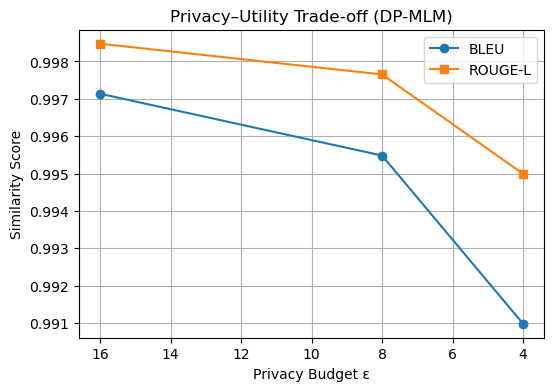

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# If you've already saved multiple CSVs for ε = {16, 8, 4}
eps_values = [16, 8, 4]
cosine_scores, bleu_scores, rouge_scores = [], [], []

for eps in eps_values:
    df = pd.read_csv(f"agnews_dp{eps}.csv")
    cos_sim, bleu_s, rouge_s = evaluate_rewrites(df)
    cosine_scores.append(cos_sim)
    bleu_scores.append(bleu_s)
    rouge_scores.append(rouge_s)

# --- Plot BLEU and ROUGE-L vs epsilon ---
plt.figure(figsize=(6, 4))
plt.plot(eps_values, bleu_scores, marker='o', label='BLEU')
plt.plot(eps_values, rouge_scores, marker='s', label='ROUGE-L')
plt.xlabel("Privacy Budget ε")
plt.ylabel("Similarity Score")
plt.title("Privacy–Utility Trade-off (DP-MLM)")
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # higher ε = less privacy, so flip axis if you like
plt.show()


In [81]:
import pandas as pd
df = pd.read_csv("imdb_rewrite_demo.csv")
df["changed"] = (df["original"] != df["rewritten"])
print("Average changed ratio:", (df["changed"].sum() / len(df)))


Average changed ratio: 0.04


In [103]:
import pandas as pd

df_imdb = pd.read_csv("imdb_rewrite_demo.csv")

df_imdb.head(3)


,original,rewritten
0,I rented I AM CURIOUS-YELLOW from my video sto...,I rented I AM CURIOUS-YELLOW from my video sto...
1,"""I Am Curious: Yellow"" is a risible and preten...","""I Am Curious: Yellow"" is a risible and preten..."
2,If only to avoid making this type of film in t...,If only to avoid making this type of film in t...
